## Interpretation of TF models trained on UniRef90 dataset for multiclass classification

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/..']

In [2]:
from prediction.models.nlp import transformer
from src.utils import utils, nn_utils

import torch
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


### Load the trained model

In [3]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230501/host_multi/transformer-crossentropy_itr4.pth"


label_groupings = {"Human": [ "Homo sapiens" ],
                  "Desert warthog": [ "Phacochoerus aethiopicus" ],
                  "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
                  "Horse": [ "Equus caballus" ],
                  "Goat": [ "Capra hircus" ],
                  "Red junglefowl": [ "Gallus gallus" ],
                  "Wood mouse": [ "Apodemus sylvaticus" ],
                  "Cattle": [ "Bos taurus" ],
                  "Others": [ "*" ]}
host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1024,
    "pad_sequence_val": 0,
    "truncate": True
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1024,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 9,
    "n_epochs": 10,
    "dim": 512
}

In [4]:
nlp_model = transformer.get_transformer_model(model)
# nlp_model = ClassificationTransformer(n_tokens=27, seq_len=sequence_settings["sequence_max_length"], n_classes=len(host_classes), N=6, d=512, d_ff=2048, h=8)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): Embedding(1024, 512)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=2048, bias=True)
          (W_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=9, b

### Load the datasets

In [5]:
def load_dataset(input_dir, input_file_names, sequence_settings):
    df = utils.read_dataset(input_dir, input_file_names, cols=[sequence_settings["sequence_col"], label_settings["label_col"]])
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

def load_dataset_with_df(df, sequence_settings):
    df = df[[sequence_settings["sequence_col"], label_settings["label_col"]]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

In [6]:
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635"
train_file_names = ["uniref90_final.csv_tr0.8_train.csv"]
test_file_names = ["uniref90_final.csv_tr0.8_test.csv"]

In [7]:
index_label_map, train_dataset_loader = load_dataset(input_dir, train_file_names, train_sequence_settings)
for _, record in enumerate(train_dataset_loader):
    sequence, label = record
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)
    break

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_train.csv, size = (15274, 2)
Size of input dataset = (15274, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 3 0 6 5 1 2 8 7]
torch.Size([8, 1024])
tensor([[10, 15,  6,  ...,  0,  0,  0],
        [21,  3,  2,  ...,  0,  0,  0],
        [11, 15,  2,  ...,  0,  0,  0],
  

In [8]:
index_label_map, test_dataset_loader = load_dataset(input_dir, test_file_names, test_sequence_settings)
for _, record in enumerate(test_dataset_loader):
    sequence, label = record
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)
    break

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_test.csv, size = (3819, 2)
Size of input dataset = (3819, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 5 3 1 7 8 6 0 2]
torch.Size([1, 1024])
tensor([[ 8, 14, 14,  ...,  0,  0,  0]], device='cuda:0')
torch.Size([1])
tensor([4], device='cuda:0')


### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [9]:
def compute_training_set_representations(train_dataset_loader):
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(train_dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.encoder.encoding
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

In [10]:
train_rep_df = compute_training_set_representations(train_dataset_loader)

(15274, 513)


In [11]:
from sklearn.manifold import TSNE

def visualize_training_dataset(train_rep_df):
    columns = train_rep_df.columns
    print(columns)
    X = train_rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    print(X_emb)
    X_emb["label"] = train_rep_df["label"].values
    return tsne_model, X_emb
    

In [12]:
tsne_model, X_emb = visualize_training_dataset(train_rep_df)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           503,     504,     505,     506,     507,     508,     509,     510,
           511, 'label'],
      dtype='object', length=513)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.010s...
[t-SNE] Computed neighbors for 15274 samples in 7.759s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.917130
[t-SNE] KL divergence after 1000 iterations: 1.064512
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.006s...
[t-SNE] Computed neighbors for 15274 samples in 6.773s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.917305
[t-SNE] KL divergence after 1000 iterations: 1.062835
(15274, 2)
               0          1
0     -46.067543  39.094425
1     -61.036968 -24.942244
2     -41.620964  38.445889
3       1.342752 -30.810900
4      36.581680  27.170382
...          ...        ...
15269  48.231117  -0.220173
15270 -75.357796 -19.243341
15271 -57.647419  13.176812
15272 -60.796394 -24.467106
15273  30.728205  31.818346

[15274 rows x 2 columns]


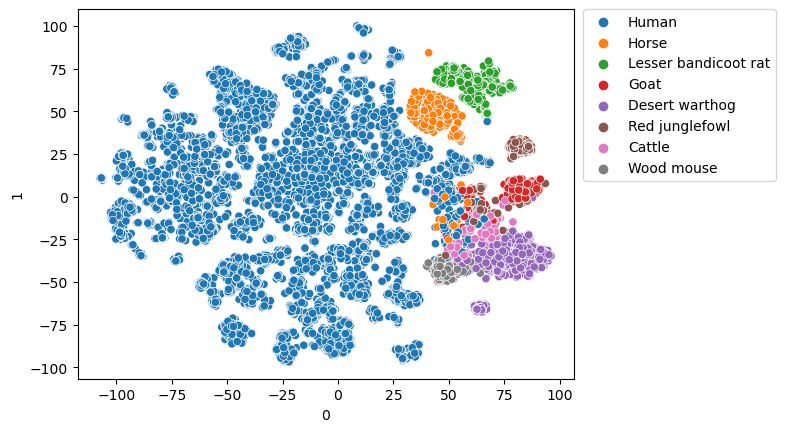

In [14]:
rep_df = X_emb.copy()
rep_df["label"] = rep_df["label"].map(index_label_map)
rep_df = rep_df[rep_df["label"] != "Others"]
ax = sns.scatterplot(data = rep_df, x=0, y=1, hue="label")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [15]:
def visualize_prediction(seq, label, train_rep_df):
    nlp_model.eval()
    output = nlp_model(seq)
    seq_encoding = nlp_model.encoder.encoding
    seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)

    seq_df = pd.DataFrame(seq_encoding.squeeze(1).cpu().detach().numpy())
    seq_df["label"] = label.squeeze().cpu().detach().numpy()
    sample_pred = torch.argmax(F.softmax(output, dim=1), dim=1)
    print(f"Label {label} = {index_label_map[label.item()]}")
    sample_pred_mapped = index_label_map[sample_pred.item()]
    print(f"Prediction {sample_pred}= {sample_pred_mapped}")
    seq_df["label"] = "prediction-" + sample_pred_mapped
    
    train_rep_df_copy = train_rep_df.copy()
    train_rep_df_copy["label"] = train_rep_df["label"].map(index_label_map)
    train_rep_df_copy = train_rep_df_copy[train_rep_df_copy["label"] != "Others"]
    train_seq_df = pd.concat([train_rep_df_copy, seq_df])
    print(f"train_seq_df shape = {train_seq_df.shape}")
    X = train_seq_df[range(512)]
    print(f"X shape = {X.shape}")
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(f"X_emb shape = {X_emb.shape}")
    X_emb["label"] = train_seq_df["label"].values
    print(f"X_emb shape = {X_emb.shape}")
    sns.scatterplot(data = X_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

Label tensor([4], device='cuda:0') = Human
Prediction tensor([4], device='cuda:0')= Human
train_seq_df shape = (14663, 513)
X shape = (14663, 512)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14663 samples in 0.027s...
[t-SNE] Computed neighbors for 14663 samples in 5.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14663
[t-SNE] Computed conditional probabilities for sample 2000 / 14663
[t-SNE] Computed conditional probabilities for sample 3000 / 14663
[t-SNE] Computed conditional probabilities for sample 4000 / 14663
[t-SNE] Computed conditional probabilities for sample 5000 / 14663
[t-SNE] Computed conditional probabilities for sample 6000 / 14663
[t-SNE] Computed conditional probabilities for sample 7000 / 14663
[t-SNE] Computed conditional probabilities for sample 8000 / 14663
[t-SNE] Computed conditional probabilities for sample 9000 / 14663
[t-SNE] Computed conditional probabilities for sample 10000 / 14663
[t-SNE] Computed conditional probabilit

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.352257
[t-SNE] KL divergence after 1000 iterations: 1.014023
X_emb shape = (14663, 2)
X_emb shape = (14663, 3)


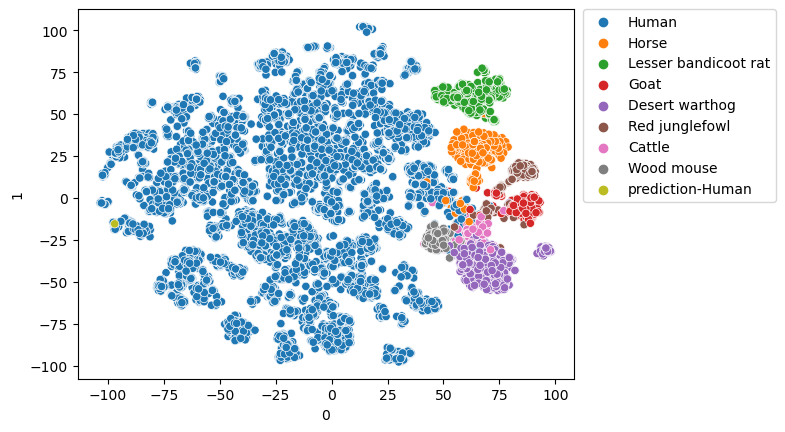

In [16]:
for _, record in enumerate(test_dataset_loader):
    seq, label = record
    visualize_prediction(seq, label, train_rep_df)
    break

#### Coronavirus only

In [17]:
uniref90_coronaviruses_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts.csv")

### Training-based interpretation
#### Encoding visualization - coronaviradae - humans only

In [18]:
uniref90_coronaviruses_df.head()

,id,seq,virus,seq_len,virus_host,binary_label
0,A3EX94,MTLLMCLLMSLLIFVRGCDSQFVDMSPASNTSECLESQVDAAAFSK...,Bat coronavirus HKU4 (BtCoV) (BtCoV/HKU4/2004),1352,Tylonycteris pachypus (Lesser bamboo bat) (Ves...,Not Human
1,A3EXD0,MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFES...,Bat coronavirus HKU5 (BtCoV) (BtCoV/HKU5/2004),1352,Pipistrellus abramus (Japanese pipistrelle) (P...,Not Human
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
3,P11223,MLVTPLLLVTLLCALCSAVLYDSSSYVYYYQSAFRPPSGWHLQGGA...,Avian infectious bronchitis virus (strain Beau...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human
4,P12651,MLVTPLLLVTLLCVLCSAALYDSSSYVYYYQSAFRPPNGWHLHGGA...,Avian infectious bronchitis virus (strain M41)...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human


In [19]:
uniref90_coronaviruses_df["virus_host"].value_counts()

Sus scrofa (Pig) [TaxID: 9823]                                                                  2620
Homo sapiens (Human) [TaxID: 9606]                                                              2400
Meleagris gallopavo (Wild turkey) [TaxID: 9103]                                                   36
Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]      19
Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]                  17
Gallus gallus (Chicken) [TaxID: 9031]                                                             13
Bos taurus (Bovine) [TaxID: 9913]                                                                 10
Name: virus_host, dtype: int64

In [20]:
uniref90_coronaviruses_humans_df = uniref90_coronaviruses_df[uniref90_coronaviruses_df["virus_host"] == "Homo sapiens (Human) [TaxID: 9606]"]
print(uniref90_coronaviruses_humans_df.shape)
uniref90_coronaviruses_humans_df.head()

(2400, 6)


,id,seq,virus,seq_len,virus_host,binary_label
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
5,P15423,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...,Human coronavirus 229E (HCoV-229E),1173,Homo sapiens (Human) [TaxID: 9606],Human
12,P36334,MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...,Human coronavirus OC43 (HCoV-OC43),1353,Homo sapiens (Human) [TaxID: 9606],Human
14,Q0ZME7,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N5) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human
15,Q14EB0,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N2) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human


In [21]:
uniref90_coronaviruses_humans_df["virus_host"] = "Homo sapiens"
uniref90_coronaviruses_humans_df.rename(columns={"virus_host": "virus_host_name"}, inplace=True)
uniref90_coronaviruses_humans_df.head()

/tmp/ipykernel_6846/804901245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniref90_coronaviruses_humans_df["virus_host"] = "Homo sapiens"
/tmp/ipykernel_6846/804901245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniref90_coronaviruses_humans_df.rename(columns={"virus_host": "virus_host_name"}, inplace=True)


,id,seq,virus,seq_len,virus_host_name,binary_label
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens,Human
5,P15423,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...,Human coronavirus 229E (HCoV-229E),1173,Homo sapiens,Human
12,P36334,MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...,Human coronavirus OC43 (HCoV-OC43),1353,Homo sapiens,Human
14,Q0ZME7,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N5) (HCoV-HKU1),1351,Homo sapiens,Human
15,Q14EB0,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N2) (HCoV-HKU1),1351,Homo sapiens,Human


min seq len = 35
max seq len = 1366


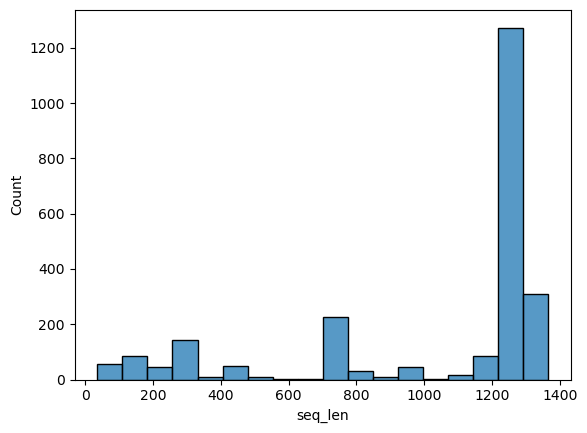

In [22]:
sns.histplot(uniref90_coronaviruses_humans_df["seq_len"])
print(f"min seq len = {min(uniref90_coronaviruses_humans_df['seq_len'])}")
print(f"max seq len = {max(uniref90_coronaviruses_humans_df['seq_len'])}")
plt.show()

In [23]:
_, dataset_loader = load_dataset_with_df(uniref90_coronaviruses_humans_df, train_sequence_settings)


Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4]


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [24]:
rep_df = compute_training_set_representations(dataset_loader)

(2400, 513)


In [25]:
tsne_model, X_emb = visualize_training_dataset(rep_df)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           503,     504,     505,     506,     507,     508,     509,     510,
           511, 'label'],
      dtype='object', length=513)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.002s...
[t-SNE] Computed neighbors for 2400 samples in 0.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 0.000000


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.721447
[t-SNE] KL divergence after 1000 iterations: 0.304577
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.001s...
[t-SNE] Computed neighbors for 2400 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 0.000000


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.724155
[t-SNE] KL divergence after 1000 iterations: 0.304054
(2400, 2)
              0          1
0    -36.670353 -12.380647
1    -23.556305 -45.965038
2     35.696224 -11.105518
3     14.631441 -33.259605
4     12.437817  45.060734
...         ...        ...
2395  -3.357706 -27.202463
2396  16.941055 -33.753120
2397 -18.263792 -44.541721
2398  20.495352  20.583746
2399  -4.737879 -16.467251

[2400 rows x 2 columns]


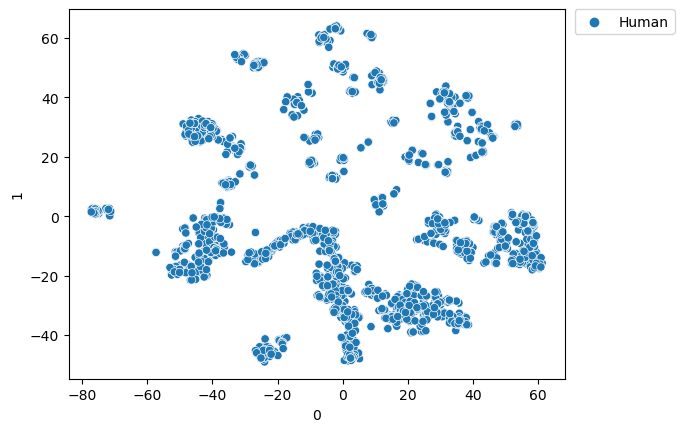

In [26]:
rep_df = X_emb.copy()
rep_df["label"] = rep_df["label"].map(index_label_map)
rep_df = rep_df[rep_df["label"] != "Others"]
ax = sns.scatterplot(data = rep_df, x=0, y=1, hue="label")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Testing-based interpretation
#### Attention based interpretation

In [27]:
def compute_mean_attn_values():
    attn_values = nlp_model.encoder.layers[5].self_attn.self_attn.squeeze()
    return torch.mean(attn_values, dim=0)


def plot_mean_attention_values(x, seq=None, seq_len=None):
    ticklabels = seq.cpu().detach().numpy().squeeze()[:seq_len]
    ticklabels_mapped = [idx_amino_acid_map[x] for x in ticklabels]

    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.figure(figsize=(12,12))
    data = x.cpu().detach().numpy()
    
    sns.heatmap(data=data[:seq_len, :seq_len], xticklabels=ticklabels_mapped, yticklabels=ticklabels_mapped)
    #plt.xticks(rotation=20)
    plt.show()


def plot_mean_of_mean_attention_values(x, seq=None, seq_len=None, seq_max_length=None):
    tokens = seq.cpu().detach().numpy().squeeze()
    
    x = torch.mean(x, dim=0)
    df = pd.DataFrame({"tokens": tokens, "attn_vals": x.cpu().detach().numpy(), "pos": range(seq_max_length)})
    df["tokens"] = df["tokens"].map(idx_amino_acid_map)
    df = df.dropna()
    sorted_df = df.sort_values(by="attn_vals", ascending=False).head(10)
    print("Top 10 tokens + positions with highest attention values for the whole sequence")
    print(sorted_df.head(10))
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df, x="pos", y="attn_vals", hue="tokens")
    plt.show()

In [28]:
def analyze_attention_of_prediction(sample_seq, sample_label, seq_max_length):
    # sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(sample_seq.shape)
    print(f"seq_len = {seq_len}")
    
    nlp_model.eval()
    output = nlp_model(sample_seq)
    sample_pred = torch.argmax(F.softmax(nlp_model(sample_seq), dim=1), dim=1)
    print(f"Label = {index_label_map[sample_label.item()]}")
    print(f"Prediction = {index_label_map[sample_pred.item()]}")
    mean_attn_values = compute_mean_attn_values()

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len, seq_max_length=seq_max_length) 

In [29]:
def analyze_attention_of_df(dataset_loader, seq_max_length):
    attn_dfs = []
    max_seq_len_actual = 0
    for _, record in enumerate(dataset_loader):
        seq, label = record
        seq_len = torch.count_nonzero(seq).item()
        #print(seq_len)
        if seq_len > max_seq_len_actual:
            max_seq_len_actual = seq_len
        nlp_model(seq)
        mean_attn_values = compute_mean_attn_values()
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        attn_dfs.append(mean_of_mean.cpu().detach().numpy())
    print("max_seq_len_actual = ", max_seq_len_actual)
    attn_df = np.concatenate(attn_dfs, axis=0)
    plt.figure(figsize=(12,12))
    sns.heatmap(data=attn_df[:,:max_seq_len_actual])

Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4]
torch.Size([1, 1024])
seq_len = 1024
Label = Human
Prediction = Human


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

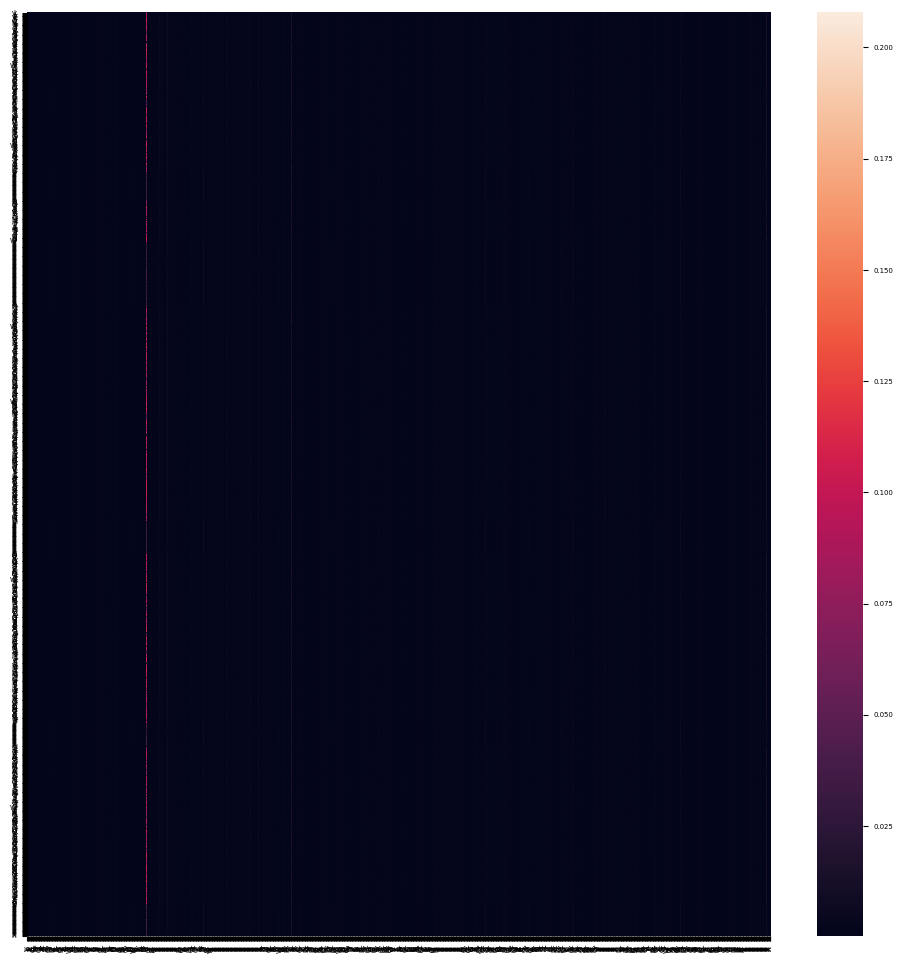

Top 10 tokens + positions with highest attention values for the whole sequence
     tokens  attn_vals   pos
256       X   0.081157   256
165       Y   0.073757   165
364       Y   0.012792   364
1018      X   0.011039  1018
193       X   0.007252   193
996       X   0.005446   996
243       Y   0.005230   243
899       Y   0.005099   899
319       X   0.004903   319
812       X   0.004577   812


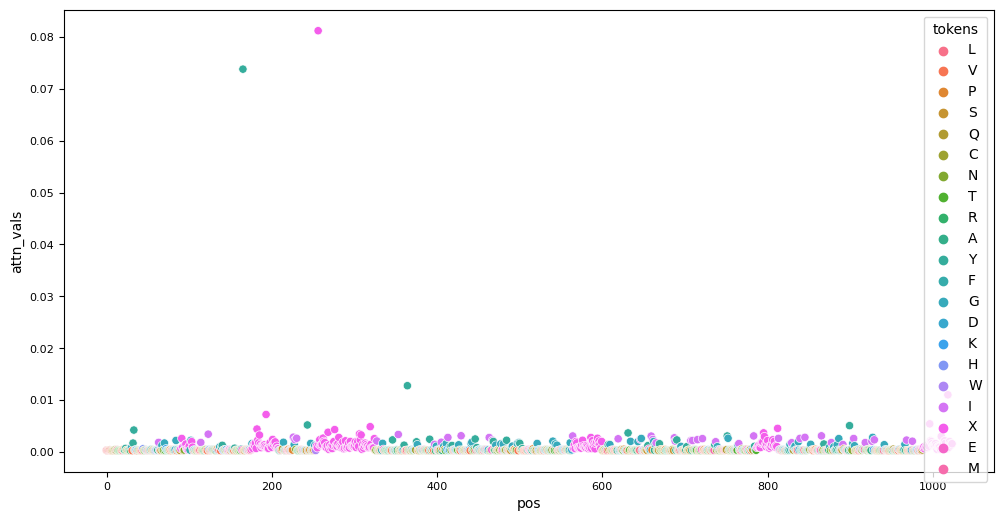

In [33]:
_, dataset_loader = load_dataset_with_df(uniref90_coronaviruses_humans_df, test_sequence_settings)

for _, record in enumerate(dataset_loader):
    seq, label = record
    analyze_attention_of_prediction(seq, label, test_sequence_settings["max_sequence_length"])
    break

2400
max_seq_len_actual =  1024


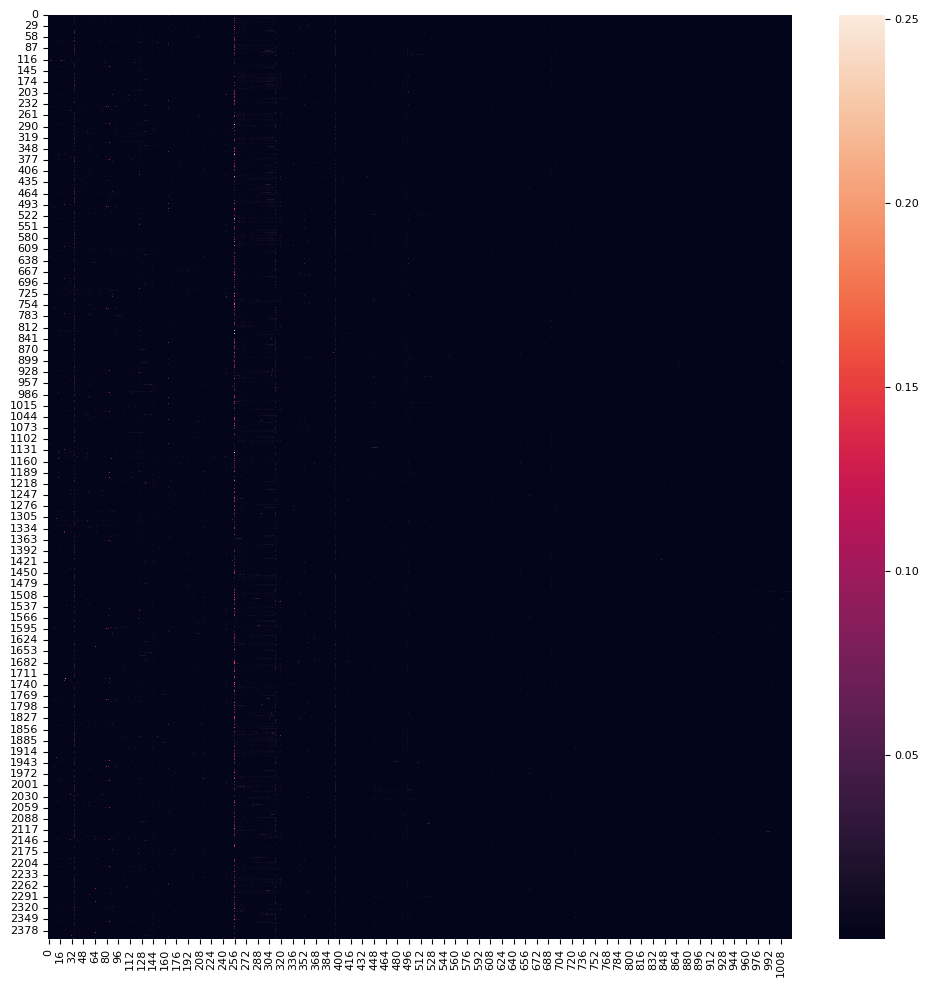

In [31]:
print(len(dataset_loader))
analyze_attention_of_df(dataset_loader, test_sequence_settings["max_sequence_length"])

In [45]:
from Bio import motifs
from Bio.Seq import Seq
from Bio.Alphabet import generic_protein

ImportError: Bio.Alphabet has been removed from Biopython. In many cases, the alphabet can simply be ignored and removed from scripts. In a few cases, you may need to specify the ``molecule_type`` as an annotation on a SeqRecord for your script to work correctly. Please see https://biopython.org/wiki/Alphabet for more information.

In [43]:
instances = []
for s in uniref90_coronaviruses_humans_df["seq"]:
    if len(s) >= 900:
        instances.append(Seq(s[:900]))

In [44]:
m = motifs.create(instances, alphabet=generic_protein)

KeyError: 'M'